In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             classification_report, roc_auc_score, plot_roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # Hyperparameter tuning
from sklearn.metrics import plot_confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance 
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

def wrangle():
    #read in all 5 documents, all store different info with nothing but keys duplicated
    order_meta = pd.read_csv('orders.csv')
    print('order_meta: ',order_meta.shape)
    
    order_products_train = pd.read_csv('order_products__train.csv')
    print('order_products_train: ',order_products_train.shape)

    products = pd.read_csv('products.csv')
    print('products: ',products.shape)
    
    orders_meta_products = order_products_train.merge(order_meta, how = 'left', left_on ='order_id', 
                                            right_on = 'order_id') 

    master = products.merge(orders_meta_products, how = 'right', left_on ='product_id', 
                                      right_on = 'product_id')
    
    #generate counts for unique items in descending order by count
    freq = master['product_id'].value_counts()
    #reset product_id info index to column and provide default numerical index
    freq = freq.reset_index()
    #rename columns to familiar names
    freq.columns = ['product_id', 'instance_count']

    #put counts back into table
    master = master.merge(freq, how = 'left')

    #generate feature for items purchased only once
#    master['Uncommon?'] = (master['instance_count'] == 1).astype(int)
    
    #generate feature for top 100 most commonly purchased items
    master['Staple?'] = (master['instance_count'] > 1350).astype(int)
    
    #generate column asking whether string 'Organic' is present in item name
    master['Organic?'] = master['product_name'].str.contains('Organic', regex = False).astype(int)

    #generate all of the features that refer to aisle/dept categories
#    master['Alcohol?'] = (master['department_id'] == 5).astype(int)
    master['Produce?'] = (master['department_id'] == 4).astype(int)
    master['Beverage?'] = (master['department_id'] == 7).astype(int)
#    master['Household?'] = (master['department_id'] == 17).astype(int)

#    master['PetsBabies?'] = ((master['department_id'] == 8) | (master['department_id'] == 18)).astype(int)
    master['NonFood?'] = ((master['department_id'] == 8) |  #pets
                           (master['department_id'] == 18) |#babies
                           (master['department_id'] == 11) |#personal care
                           (master['department_id'] == 17)  #household
                            ).astype(int)
    master['Prepared?'] = ((master['department_id'] == 14) |#breakfast
                           (master['department_id'] == 20) |#deli
                           (master['department_id'] == 3)  |#bakery
                           (master['aisle_id'] == 38) |     #frozen meals
                           (master['aisle_id'] == 52) |     #frozen breakfast
                           (master['aisle_id'] == 79) |     #frozen pizza
                           (master['aisle_id'] == 129) |    #frozen sides
                           (master['aisle_id'] == 119) |    #frozen breakfast
                           (master['aisle_id'] == 37) |     #frozen pizza
                           (master['aisle_id'] == 59)       #canned meals beans
                            ).astype(int)
    master['JunkFood?'] = ((master['department_id'] == 19) |#snacks
                           (master['aisle_id'] == 8) |      #bakery desserts
                           (master['aisle_id'] == 37) |     #frozen ice cream 
                           (master['aisle_id'] == 119)      #frozen dessert
                            ).astype(int)
    
    #generate ranking within categories containing for the most orders to least
    ranked_aisle = master['aisle_id'].value_counts().rank().rename('aisle_rank')
    ranked_hour = master['order_hour_of_day'].value_counts().rank().rename('hour_rank')
    ranked_dept = master['department_id'].value_counts().rank().rename('dept_rank')
    
    #incorporate rankings back into main df
    master = master.merge(ranked_aisle, how = 'left', left_on = 'aisle_id', right_index = True).merge(
        ranked_hour, how = 'left', left_on = 'order_hour_of_day', right_index = True)
    #create "popularity index" using both aisle rank and hour rank
    master['popularity_index'] = master['aisle_rank'] * master['hour_rank']/ (134*24)

    #incorporate rankings back into main df
    master = master.merge(ranked_dept, how = 'left', left_on = 'department_id', right_index = True)
    
    print(master.columns)
    #master = master.drop(columns = ['aisle_rank', 'hour_rank', ])
    
    master = master.set_index(['order_id', 'product_id'])
    
    master = master.drop(columns = ['user_id', 'eval_set', 'order_number', 'product_name'])
    
    return master



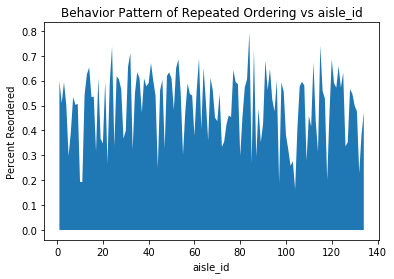

In [84]:
#create plot of percentage reordered with respect to values in a given independent features
def plot_percent_reorder_by_y(ind_column):
    #create df which includes both X and Y but does not include testing data, to avoid leakage
    df_train = X_train.merge(y_train.to_frame(), left_index=True, right_index=True)
    #count distribution of reordered status with respect to the chosen independent feature 
    counts = df_train[[ind_column,'reordered']].value_counts().reset_index()#reset multiindex into separate features
    #create total count for all observations with respect to the chosen independent feature 
    sums = counts.groupby([ind_column]).sum()[0]#0 is default column name that contains the counts
    #patch counts and total sum together to create a normalized dataframe
    norm = counts.merge(sums, how = 'left', left_on = ind_column, right_index = True)
    norm = norm.rename(columns = {'0_x' : 'count', '0_y' : 'total_count'})#give descriptive column names
    #create percent column for data interpretability
    norm['percent'] = norm['count'] / norm['total_count']
    norm = norm[norm['reordered'] == 1] #filter out redundant 0 data 
    plt.fill_between(ind_column, 'percent', data = norm.sort_values(ind_column))#sort values for graph readability
    plt.xlabel(ind_column)
    plt.ylabel('Percent Reordered')
    plt.title('Behavior Pattern of Repeated Ordering vs ' + ind_column)

plot_percent_reorder_by_y('aisle_id')   

In [94]:
df = wrangle()

target = 'reordered'
# added_features = ['Organic?', 'Alcohol?','Produce?', 'Beverage?', 'Household?', 'PetsBabies?',
#              'NonFood?', 'Prepared?', 'JunkFood?', 'Uncommon?', 'Staple?', 'instance_count']

added_features = ['Organic?', 'Alcohol?','Produce?', 'Beverage?', 'Household?', 'Uncommon?',
             'NonFood?', 'Prepared?', 'JunkFood?', 'Uncommon?', 'Staple?', 'instance_count', 'aisle_rank', 
                  'hour_rank','popularity_index', 'dept_rank',]


to_exclude = ([target, 'Alcohol?', 'Uncommon?', 'PetsBabies?', 'Household?'] )

y = df[target]
X = df.drop(columns=to_exclude)

X.head()

X_train, X_VT, y_train, y_VT = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_VT, y_VT, test_size=0.67, random_state=42)


baseline_acc = y_train.value_counts(normalize=True).iloc[0]

#standard_tests()
X_train.columns

order_meta:  (3421083, 7)
order_products_train:  (1384617, 4)
products:  (49688, 4)
Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'reordered', 'user_id', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'instance_count', 'Uncommon?', 'Staple?', 'Organic?', 'Alcohol?',
       'Produce?', 'Beverage?', 'Household?', 'PetsBabies?', 'NonFood?',
       'Prepared?', 'JunkFood?', 'aisle_rank', 'hour_rank', 'popularity_index',
       'dept_rank'],
      dtype='object')


Index(['aisle_id', 'department_id', 'add_to_cart_order', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'instance_count',
       'Staple?', 'Organic?', 'Produce?', 'Beverage?', 'NonFood?', 'Prepared?',
       'JunkFood?', 'aisle_rank', 'hour_rank', 'popularity_index',
       'dept_rank'],
      dtype='object')

In [6]:
bool_list = ['Organic?', 'Alcohol?','Produce?', 'Beverage?', 'Household?', 'PetsBabies?',
             'NonFood?', 'Prepared?', 'JunkFood?', 'Uncommon?', 'Staple?',]

#create empty DataFrame to populate with result values
results = pd.DataFrame(columns = [0, 1], index = bool_list)

for col in bool_list:
    results.loc[col, 0] = df[col].value_counts(normalize=True).loc[0] 
    results.loc[col, 1] = df[col].value_counts(normalize=True).loc[1] 
     
results = results.sort_values(by = 0, axis = 0, ascending = False)

display(results)  

,0,1
Alcohol?,0.995957,0.004043
Uncommon?,0.994306,0.00569399
PetsBabies?,0.985961,0.0140385
Household?,0.97401,0.0259899
NonFood?,0.944393,0.0556067
Beverage?,0.917634,0.0823665
JunkFood?,0.896028,0.103972
Prepared?,0.854084,0.145916
Staple?,0.772083,0.227917
Organic?,0.70707,0.29293


In [ ]:
print('Baseline Accuracy Score:', baseline_acc)

model_log = make_pipeline(
    StandardScaler(), # re-scales all features  (mean = 0, std=1)
    LogisticRegression()
)

model_log.fit(X_train, y_train);
train_acc_log = accuracy_score(y_train, model_log.predict(X_train))
val_acc_log = accuracy_score(y_val, model_log.predict(X_val))

print('Logistic Classifier')
print('Training Accuracy Score:', train_acc_log)
print('Validation Accuracy Score:', val_acc_log)


In [76]:
n_est = 120 
max_dep = 15
max_feat = 7

model_bag = make_pipeline(
    RandomForestClassifier(n_estimators= n_est,  
                           max_features= max_feat, 
                           max_depth= max_dep, 
                           random_state= 42, n_jobs= -1, verbose = 1))



model_bag.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.4min finished


In [85]:
train_acc_bag = accuracy_score(y_train, model_bag.predict(X_train))
val_acc_bag = accuracy_score(y_val, model_bag.predict(X_val))
test_acc_bag = accuracy_score(y_test, model_bag.predict(X_test))

print('baseline accuracy:', baseline_acc)
print('Training Accuracy Score:', train_acc_bag)
print('Validation Accuracy Score:', val_acc_bag)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s


baseline accuracy: 0.5977780827161341
Training Accuracy Score: 0.7297895082748634
Validation Accuracy Score: 0.6633570912698702
Testing Accuracy Score: 0.6623638875564347


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.2s finished


Text(0.5, 0, 'gini importance')

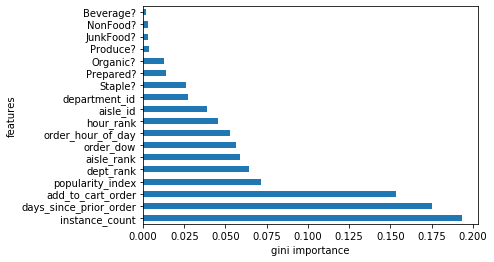

In [78]:
gini = model_bag.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
importances = pd.Series(data=gini, index=features).sort_values(ascending = False)
importances.plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')

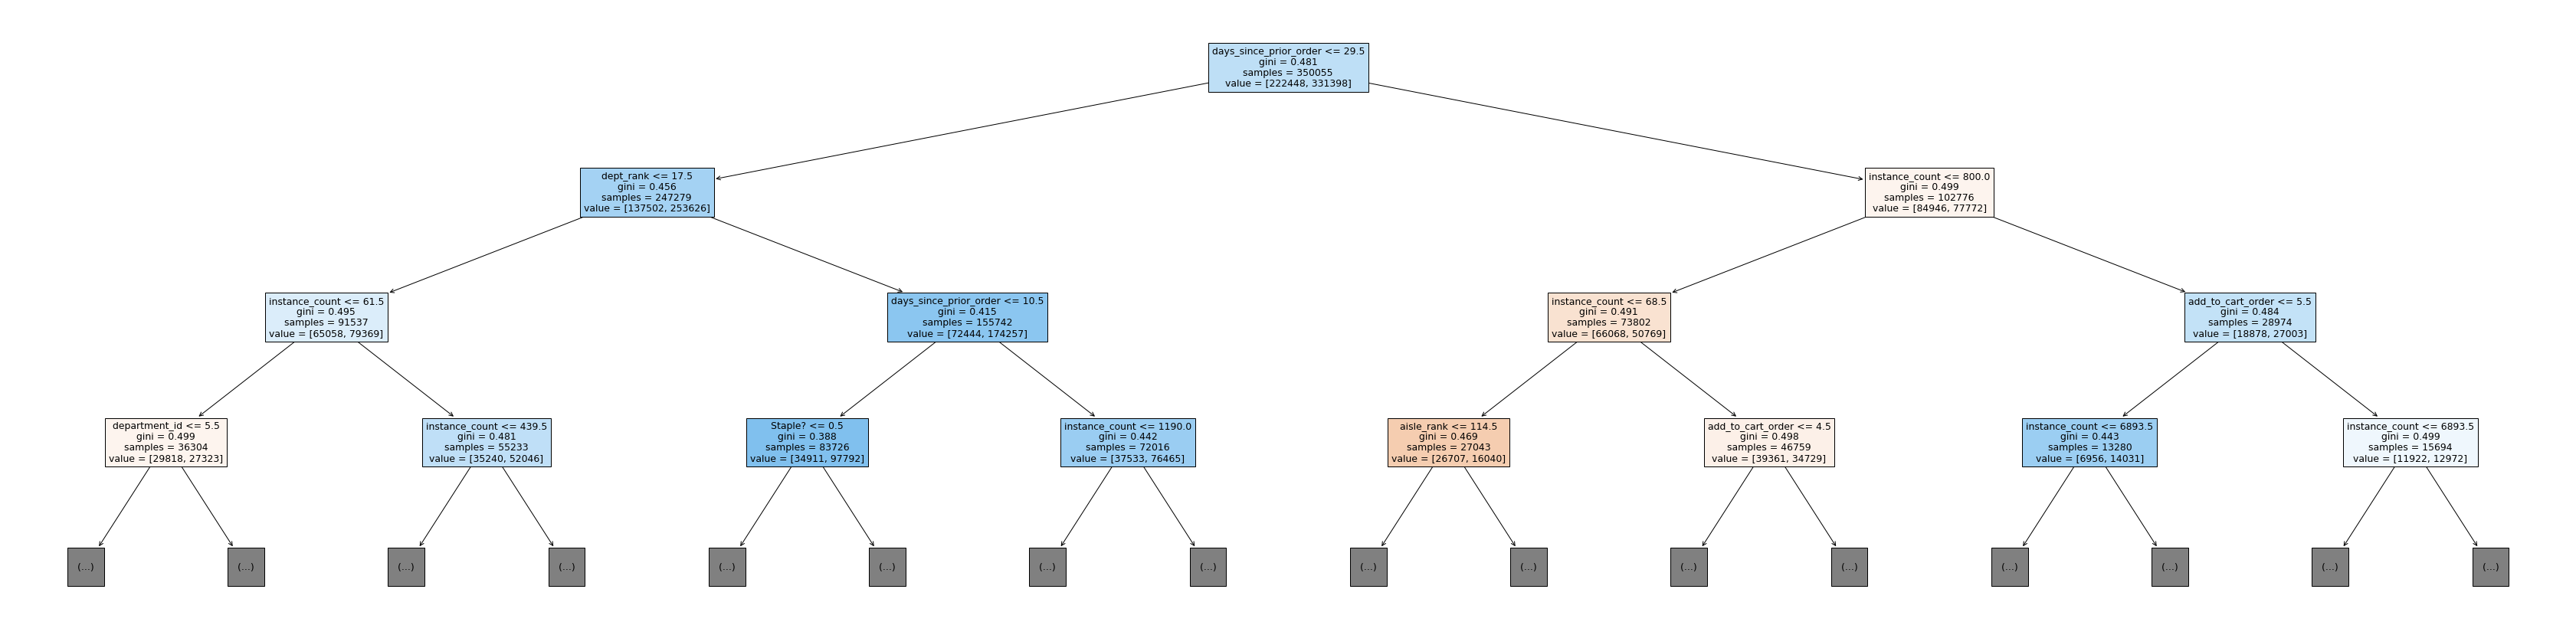

In [82]:
plt.figure(figsize=(60,15));
plot_tree(model_bag.named_steps['randomforestclassifier'].estimators_[0],
         max_depth=3,
         feature_names=X_train.columns,
         filled=True
         );

In [45]:
to_try = list(range(14,19, 1))
#to_try = [2,3]
n_est = 100 #100 best, but slow
max_dep = 15
max_feat = 7
min_leaf = 2

for trial in to_try:
 rf_model = make_pipeline(
 RandomForestClassifier(n_estimators=n_est, max_depth = trial,
                        max_features = 7, 
                     random_state=42, n_jobs=-1, verbose = 1)
    )

 rf_model.fit(X_train, y_train)
 train = rf_model.score(X_train, y_train)
 val = rf_model.score(X_val, y_val)

 print('n_estimators: ', trial, '\nTrain: ', train, '\nVal: ', val )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


n_estimators:  14 
Train:  0.7038274177298383 
Val:  0.663565003611109


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished


n_estimators:  15 
Train:  0.7223361728711591 
Val:  0.6636306601399213


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.5s finished


n_estimators:  16 
Train:  0.745976318326755 
Val:  0.6626786404721434


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [79]:
perm_imp = permutation_importance(model_bag, X_val, y_val, random_state=10)


data_perm  = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

permutation_importances = pd.DataFrame(data_perm , index=X_val.columns).sort_values('imp_mean')

permutation_importances

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_job

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_job

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_job

,imp_mean,imp_std
hour_rank,-0.000797,0.000211
popularity_index,-0.000348,0.000233
Beverage?,-0.000024,0.000073
JunkFood?,0.000115,0.000068
Produce?,0.000162,0.000111
Organic?,0.000176,0.000200
order_hour_of_day,0.000241,0.000209
NonFood?,0.000499,0.000078
order_dow,0.000762,0.000216
Staple?,0.001548,0.000248
